In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import flax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import linen as nn
from numpyro.contrib.module import random_flax_module
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from paton_nn.model import PatonNN

%matplotlib inline

In [2]:
L = 1  # number of labels
T = 4  # number of latents
F = 32  # number of flux values
N = 1024  # number of stars

rng = np.random.default_rng(seed=8675209)

# alpha = rng.normal(0., label_scales, size=(M, K))
alpha = np.zeros((L, T))
alpha[0, 0] = 1.

beta = rng.normal(size=(F, T))

def make_data(N, rng):
    # label_scales = 10 ** rng.uniform(-2, 2, size=(M, 1))
    label_scales = jnp.ones((L, 1))

    zeta = rng.normal(size=(N, T))

    labels = (alpha @ zeta.T).T
    fluxs = (beta @ zeta.T).T

    label_err = rng.uniform(0.01, 0.1, size=labels.shape) * label_scales.T
    flux_err = rng.uniform(0.01, 0.1, size=fluxs.shape)

    obs = {
        "label": rng.normal(labels, label_err),
        "label_err": label_err,
        "flux": rng.normal(fluxs, flux_err),
        "flux_err": flux_err,
    }
    truth = {
        "label": labels,
        "flux": fluxs,
        "alpha": alpha,
        "beta": beta,
        "zeta": zeta,
    }

    return obs, truth

data, data_true = make_data(N, rng=rng)
test_data, test_data_true = make_data(N, rng=rng)

In [3]:
paton_model = PatonNN(
    n_labels=L,
    n_latents=4 * T,
    # n_hidden=(F // 4, F // 2, F),
    n_hidden=(),  # Linear model like DHD's model
    n_flux=F,
)

Test evaluating the model:

In [4]:
N_eval = 3

key = jax.random.PRNGKey(42322)
tmp_z = jax.random.normal(key, (N_eval, T))  # Dummy input data
tmp_params = paton_model.init(key, tmp_z)
paton_model.apply(tmp_params, tmp_z)

(Array([[0.57354736],
        [0.94031934],
        [0.9615976 ]], dtype=float64),
 Array([[-6.77329079e-01, -9.34938015e-01,  6.72222678e-01,
         -7.19193423e-01, -7.65066280e-01,  1.17260869e+00,
          6.20387647e-01, -9.94078623e-01,  4.61780761e-01,
          3.56005125e-02, -6.17522994e-01,  6.56230636e-01,
          2.12933510e+00,  1.31844937e+00, -6.59236946e-01,
         -5.32690369e-01, -1.58861306e+00,  1.63625422e+00,
          3.15532609e-02, -1.02185091e+00,  1.39629449e+00,
         -4.42934305e-01,  1.07367416e-01,  1.25447720e+00,
         -8.46688790e-02, -7.71097485e-01, -3.31458315e-01,
          4.97568101e-01,  1.12763253e+00, -1.18214478e+00,
         -2.06666371e-01,  1.49704172e+00],
        [ 4.88509592e-01,  3.40000149e-01, -1.63950844e+00,
         -3.15661997e-01,  3.26299321e-01, -1.00465102e+00,
          1.92147176e-01,  7.27125437e-01, -6.85265845e-01,
          3.05673444e-02,  1.79275372e-02, -1.01937553e+00,
         -1.20895868e+00, -1.2031

How many parameters does the model have?

In [5]:
np.concatenate(
    [x.ravel() for x in jax.tree_util.tree_flatten(tmp_params["params"])[0]]
).shape

(165,)

In [6]:
# Predictive(numpyro_model, num_samples=1)(jax.random.PRNGKey(0), **model_kwargs)

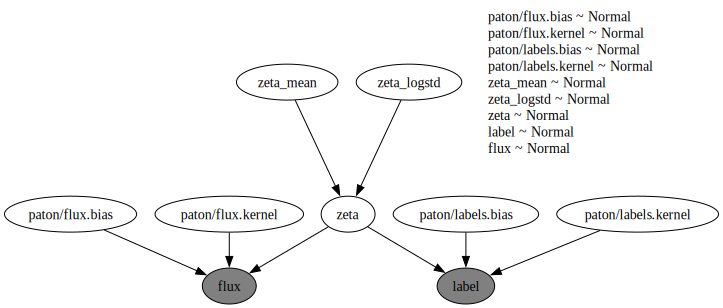

In [7]:
model_kwargs = {
    "data": data
}

test_model_kwargs = {
    "data": test_data
}

numpyro.render_model(
    model=paton_model.numpyro_model,
    model_kwargs=model_kwargs,
    render_distributions=True,
    render_params=True,
)

Optimize to get MAP parameters:

In [8]:
rng_key = jax.random.PRNGKey(112358)

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(paton_model.numpyro_model)
svi = SVI(paton_model.numpyro_model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(rng_key, 100_000, **model_kwargs)
MAP_params = svi_results.params

100%|██████████| 100000/100000 [00:40<00:00, 2462.79it/s, init loss: 72998802.2355, avg. loss [95001-100000]: -157844.4548]


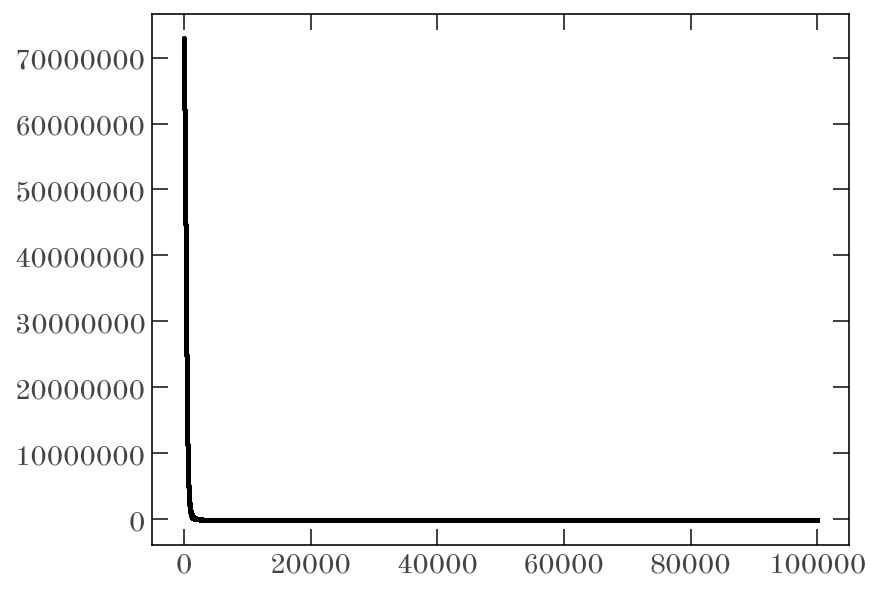

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(svi_results.losses)

In [11]:
thing = Predictive(
    model=paton_model.numpyro_model, guide=guide, params=MAP_params, num_samples=1
)
MAP_pp = thing(rng_key, **model_kwargs)

thing = Predictive(guide, params=MAP_params, num_samples=1)
MAP_p = thing(rng_key, **model_kwargs)

In [12]:
# print(MAP_p["a_label"][0], MAP_p["b_label"][0])
# print(MAP_p["a_flux"][0], MAP_p["b_flux"][0])

In [13]:
MAP_paton_params = {
    "params": {
        "labels": {
            "kernel": MAP_p["paton/labels.kernel"][0],
            "bias": MAP_p["paton/labels.bias"][0]
        },
        "flux": {
            "kernel": MAP_p["paton/flux.kernel"][0],
            "bias": MAP_p["paton/flux.bias"][0]
        }
    }
}

if hasattr(paton_model.n_hidden, "__iter__"):
    for i, n in enumerate(paton_model.n_hidden):
        MAP_paton_params["params"][f"hidden_{i}"] = {
            "kernel": MAP_p[f"paton/hidden_{i}.kernel"][0],
            "bias": MAP_p[f"paton/hidden_{i}.bias"][0]
        }
else:
    MAP_paton_params["params"]["hidden"] = {
        "kernel": MAP_p["paton/hidden.kernel"][0],
        "bias": MAP_p["paton/hidden.bias"][0]
    }

MAP_label, MAP_flux = paton_model.apply(MAP_paton_params, MAP_p["zeta"])
MAP_label = MAP_label[0]
MAP_flux = MAP_flux[0]
# MAP_label = MAP_p["a_label"][0] * MAP_label + MAP_p["b_label"][0]
# MAP_flux = MAP_p["a_flux"][0] * MAP_flux + MAP_p["b_flux"][0]

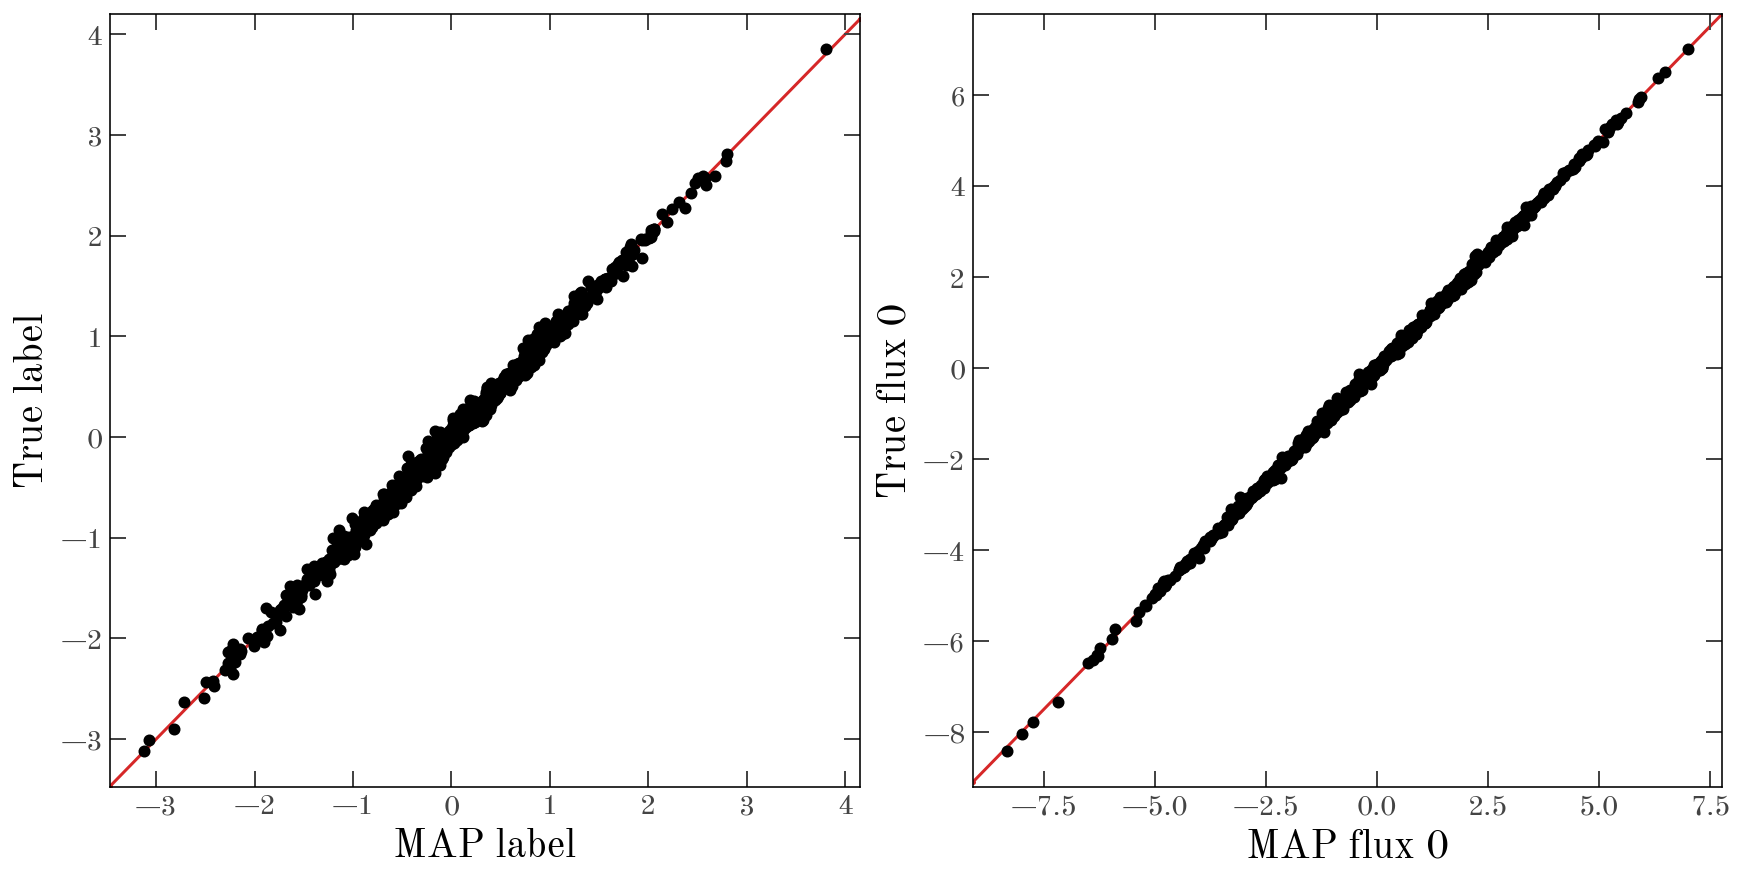

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(
    MAP_label[:, 0],
    data["label"][:, 0]
)
axes[0].set_xlabel("MAP label")
axes[0].set_ylabel("True label")
axes[0].axline([0, 0], slope=1, color="tab:red", zorder=-100)

axes[1].scatter(
    MAP_flux[:, 0],
    data["flux"][:, 0]
)
axes[1].set_xlabel("MAP flux 0")
axes[1].set_ylabel("True flux 0")
axes[1].axline([0, 0], slope=1, color="tab:red", zorder=-100)

In [15]:
np.sum((MAP_label[:, 0] - data["label"][:, 0])**2)

Array(3.9396081, dtype=float64)

In [16]:
np.sum((MAP_flux[:, 0] - data["flux"][:, 0])**2)

Array(3.73855364, dtype=float64)

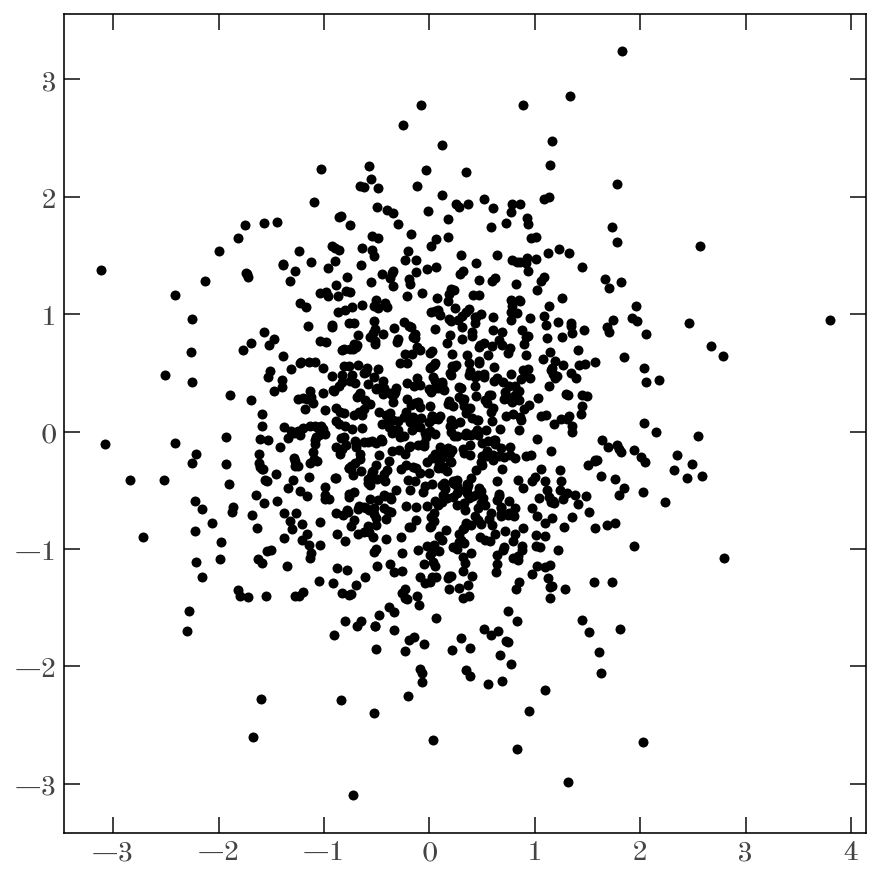

In [17]:
plt.plot(
    data_true["zeta"][:, 0],
    data_true["zeta"][:, 1],
    ls="none", marker="o"
);

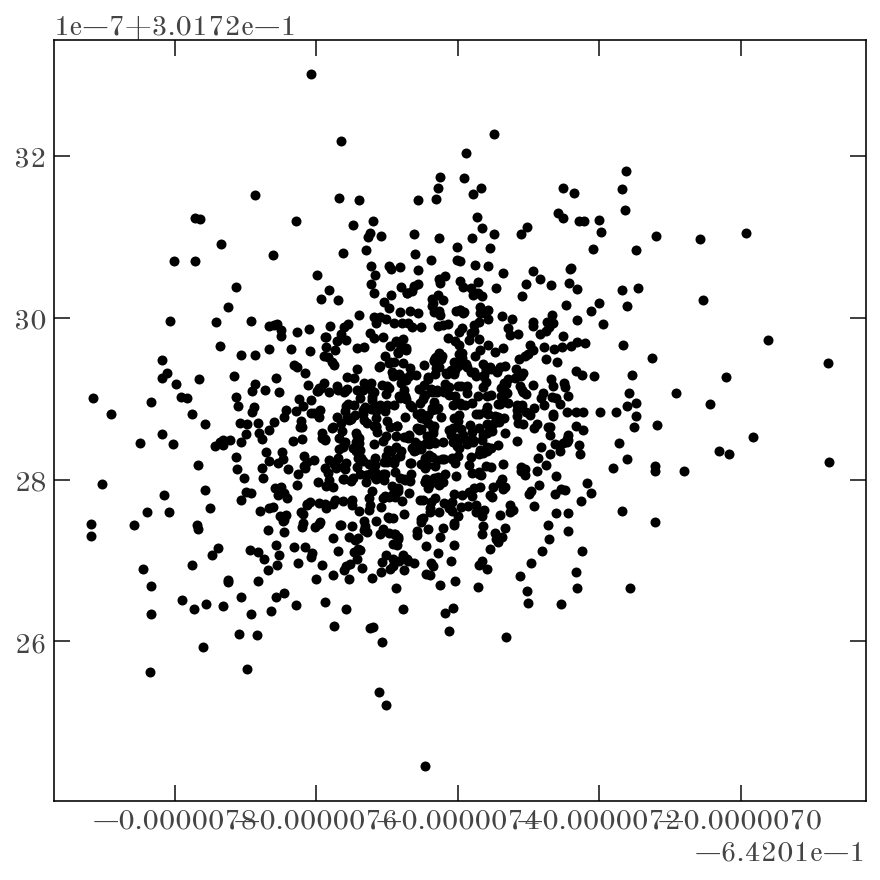

In [18]:
plt.plot(
    MAP_p["zeta"][0, :, 0],
    MAP_p["zeta"][0, :, 1],
    ls="none", marker="o"
);

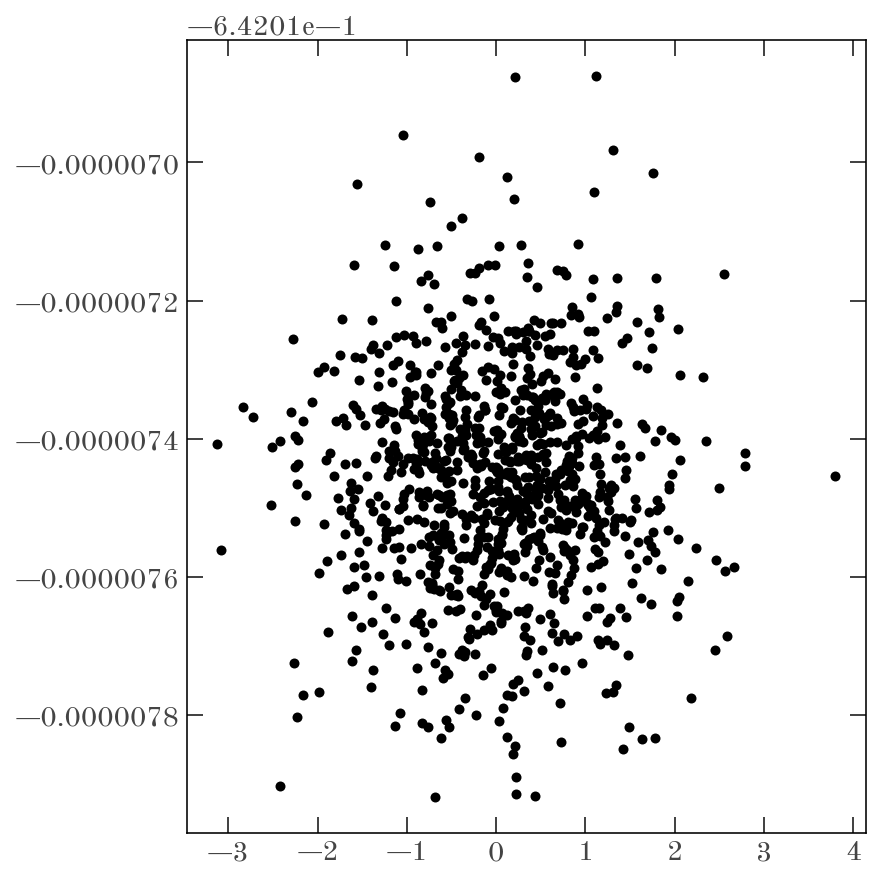

In [19]:
plt.plot(
    data_true["zeta"][:, 0],
    MAP_p["zeta"][0, :, 0],
    ls="none", marker="o"
);

## Explore the latent space

In [20]:
zeta_explore = np.zeros((128, paton_model.n_latents))
zeta_explore[:, 3] = np.linspace(-3, 3, zeta_explore.shape[0])

label_explore, flux_explore = paton_model.apply(MAP_paton_params, zeta_explore)
flux_explore = flux_explore.squeeze()

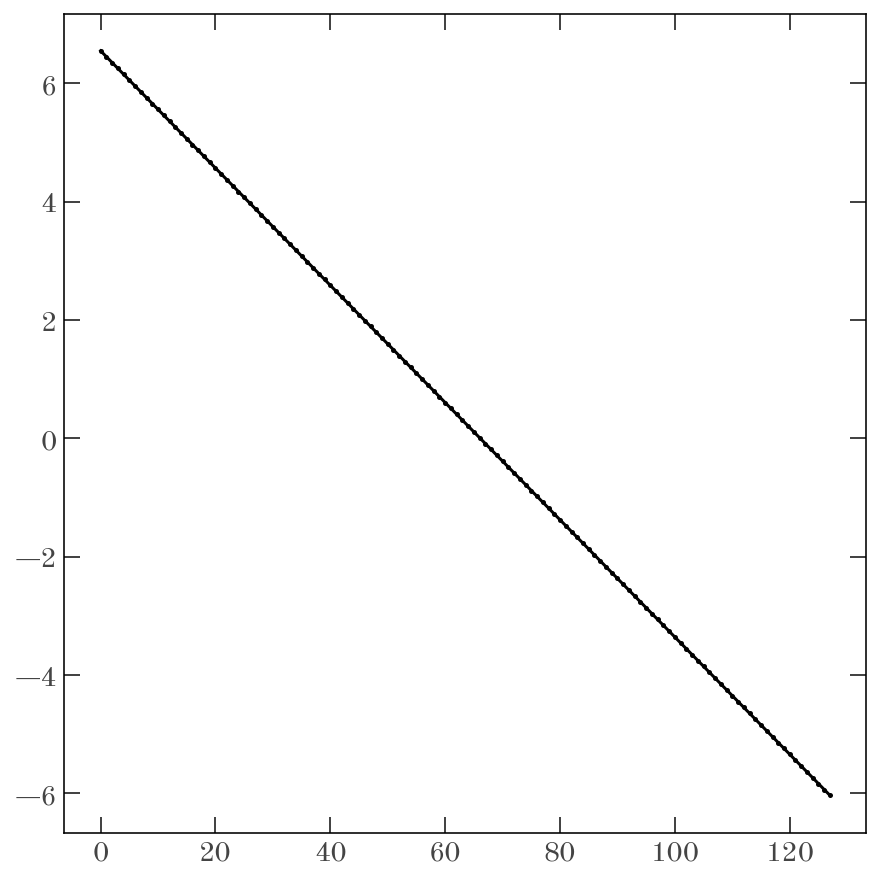

In [21]:
plt.plot(label_explore.squeeze())

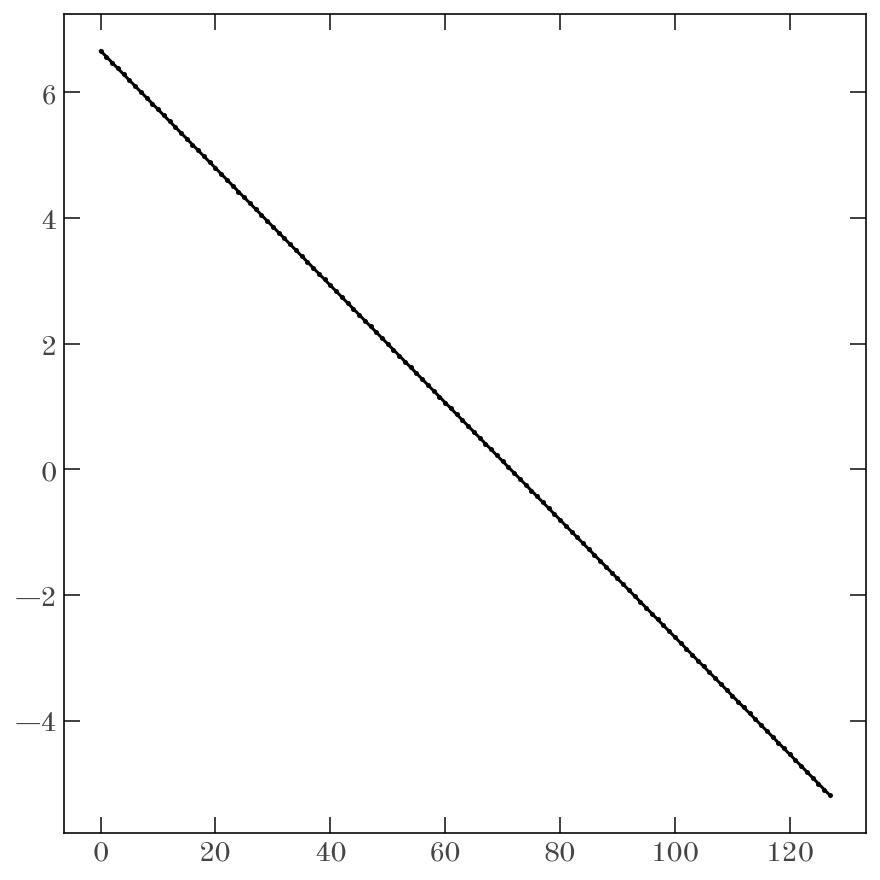

In [22]:
plt.plot(flux_explore[:, 4])

## Optimize for zeta given labels, fixed parameters, no flux

And also vice versa. 

In [23]:
# other_params = {
#     "a_label": MAP_p["a_label"][0],
#     "b_label": MAP_p["b_label"][0],
#     "a_flux": MAP_p["a_flux"][0],
#     "b_flux": MAP_p["b_flux"][0],
# }
other_params = {
    "zeta_mean": MAP_p["zeta_mean"][0],
    "zeta_logstd": MAP_p["zeta_logstd"][0],
}

Try to optimize for zeta (to get labels) given only flux:

In [24]:
rng_key = jax.random.PRNGKey(1234)

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(paton_model.numpyro_model_label)
svi = SVI(paton_model.numpyro_model_label, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    rng_key,
    20_000,
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)

thing = Predictive(
    model=paton_model.numpyro_model_label,
    guide=guide,
    params=svi_results.params,
    num_samples=1,
)
test_MAP_p = thing(
    rng_key,
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)
test_MAP_label = test_MAP_p["label"][0]

100%|██████████| 20000/20000 [00:05<00:00, 3726.28it/s, init loss: 67590244.4420, avg. loss [19001-20000]: -164371.3717]


(-5.0, 5.0)

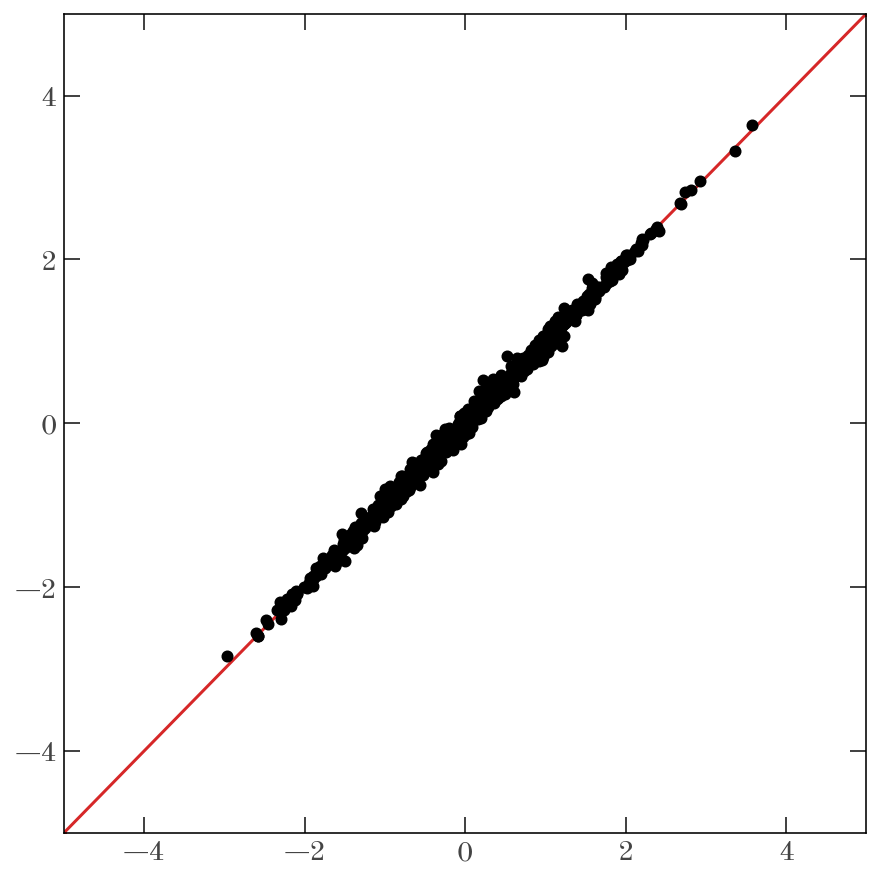

In [25]:
plt.scatter(
    test_data["label"],
    test_MAP_label
)
plt.axline([0, 0], slope=1, color="tab:red", zorder=-100)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

Try to optimize for zeta (to get flux) given only label:

In [26]:
rng_key = jax.random.PRNGKey(1234)

optimizer = numpyro.optim.Adam(1e-2)
guide = AutoDelta(paton_model.numpyro_model_flux)
# guide = AutoNormal(numpyro_model_flux)
svi = SVI(paton_model.numpyro_model_flux, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    rng_key,
    100_000,
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)

thing = Predictive(
    model=paton_model.numpyro_model_flux,
    guide=guide,
    params=svi_results.params,
    num_samples=1,
)
test_MAP_p = thing(
    rng_key,
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)
test_MAP_flux = test_MAP_p["flux"][0]

100%|██████████| 100000/100000 [00:15<00:00, 6414.15it/s, init loss: 525825.6072, avg. loss [95001-100000]: 34586.7257]


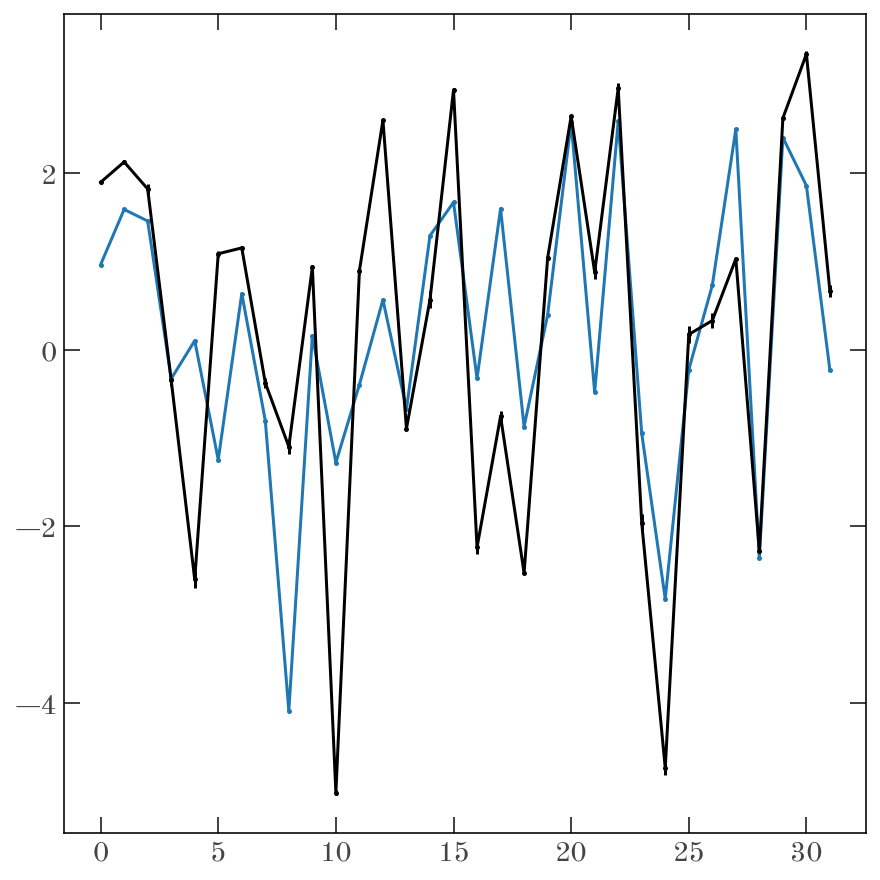

In [27]:
plt.errorbar(
    np.arange(test_data["flux"].shape[1]),
    test_data["flux"][0],
    test_data["flux_err"][0],
)
plt.plot(test_MAP_flux[0])

(-5.0, 5.0)

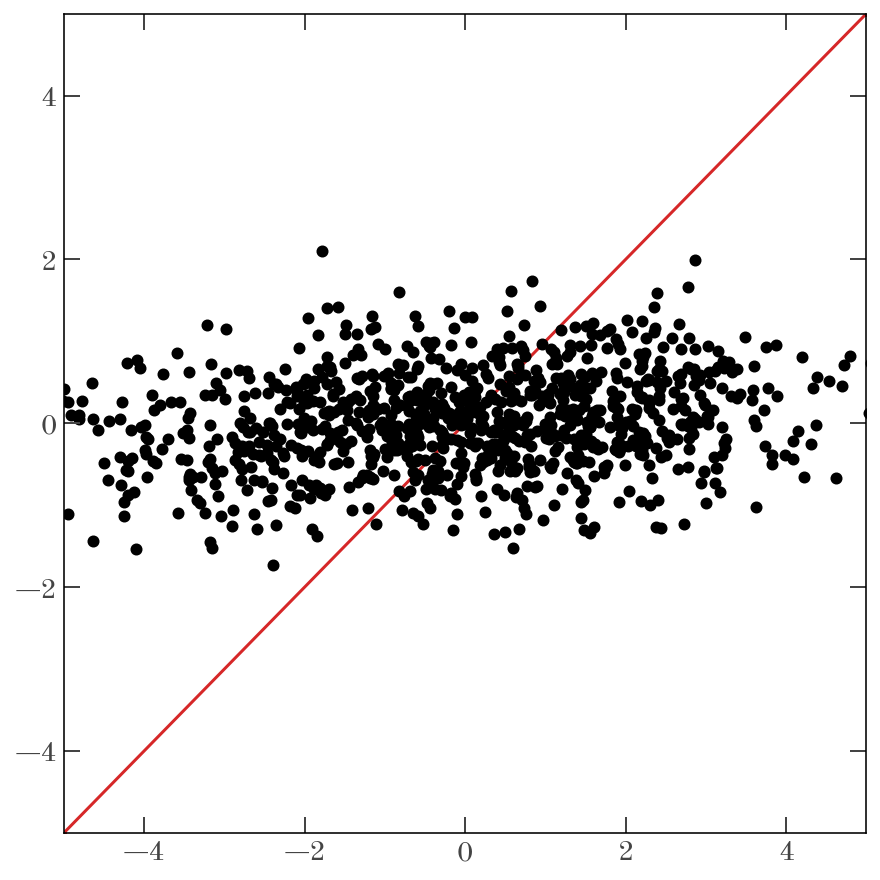

In [28]:
plt.scatter(
    test_data_true["flux"][:, 0],
    test_MAP_flux[:, 0]
)
plt.axline([0, 0], slope=1, color="tab:red", zorder=-100)

plt.xlim(-5, 5)
plt.ylim(-5, 5)